## Naive Bayes - ML


# Phase 0: Intro

**In this Notebook, we will develop Naive Bayes models to perform text classification. The dataset contains texts and the feelings correspond to each text. our goal is to make a model to predict the emotion associated with each given text.**

Importing necessary libraries

In [1]:
import nltk
import pandas
import sklearn
import string
import spacy
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

In [2]:
!pip install nltk

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
!wget -O dataset.csv "https://www.dropbox.com/scl/fi/vezn3809mk6br6jb2xari/ML-P2-DataSet.csv?rlkey=yweu1fhtvisqhxm78s4ofpxed&dl=1"

--2023-12-02 19:01:45--  https://www.dropbox.com/scl/fi/vezn3809mk6br6jb2xari/ML-P2-DataSet.csv?rlkey=yweu1fhtvisqhxm78s4ofpxed&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0bfb34ed8af04ad1837cbba8d4.dl.dropboxusercontent.com/cd/0/inline/CIqw0rbKkrLdFwOz-dIUDSdNLfatEfNuDRZRaVke9d0i1_cbMQAic14sZ-Aok9JM7LNpzZSuILjjWjxERJrycpbzS-rnVbGKGOYYUND0qZJfWdtNNy9Gv7VV3_os19_EIdMPM9BxLkhiMDs3w3-dhpMg/file?dl=1# [following]
--2023-12-02 19:01:45--  https://uc0bfb34ed8af04ad1837cbba8d4.dl.dropboxusercontent.com/cd/0/inline/CIqw0rbKkrLdFwOz-dIUDSdNLfatEfNuDRZRaVke9d0i1_cbMQAic14sZ-Aok9JM7LNpzZSuILjjWjxERJrycpbzS-rnVbGKGOYYUND0qZJfWdtNNy9Gv7VV3_os19_EIdMPM9BxLkhiMDs3w3-dhpMg/file?dl=1
Resolving uc0bfb34ed8af04ad1837cbba8d4.dl.dropboxusercontent.com (uc0bfb34ed8af04ad1837cbba8d4.dl.dropboxusercontent.com)... 

# Phase 1: Explore

## Sec 1: Load and Explore the given dataset 

Load the dataset. Look at the head of dataset.




In [5]:
ds = pd.read_csv('/kaggle/working/dataset.csv')
ds.head(10)



,Text,Feeling
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear
5,i feel jealous becasue i wanted that kind of l...,anger
6,when a friend of mine keeps telling me morbid ...,anger
7,i finally fell asleep feeling angry useless an...,anger
8,i feel a bit annoyed and antsy in a good way,anger
9,i feel like i ve regained another vital part o...,joy


In [6]:
print("Number of Rows : " + str(len(ds)))

Number of Rows : 5937


Handle missing values 

In [7]:
print("Number of missing values : " + str(ds.isnull().sum().sum()))

Number of missing values : 0


Identify the unique feeling values and for each of them, print their count in the dataset. 

In [8]:
print(ds['Feeling'].value_counts())

Feeling
anger    2000
joy      2000
fear     1937
Name: count, dtype: int64


Plot a pie chart to display the occurance frequency of each genre that you found in the prevoius part. 

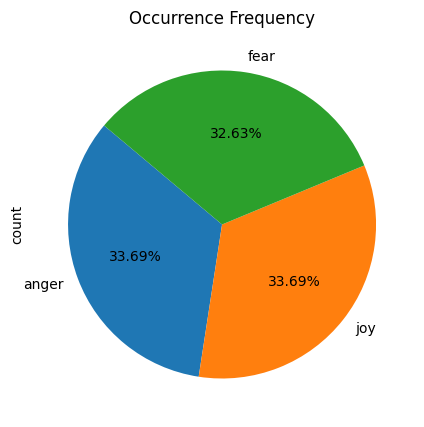

In [9]:
ds['Feeling'].value_counts().plot(kind='pie', startangle=140, figsize=(5,5), autopct='%1.2f%%')
plt.title('Occurrence Frequency')
plt.show()

Find the mean, max and min values of the length (in chars) of the Text Column. 


In [10]:
texts = ds['Text']

t_mean = texts.str.len().mean()
t_max = texts.str.len().max()
t_min = texts.str.len().min()

print("mean : " + str(t_mean))
print("max : " + str(t_max))
print("min : " + str(t_min))

mean : 97.42597271349166
max : 298
min : 9


# Phase 2: Preprocessing

## Sec 1: Preprocess the data 

In [11]:
class Preprocessor:

    def preprocess(self, text):
        text = self.remove_links_and_tags(text)
        words_lst = self.word_tokenize(text)
        words_lst = self.remove_stopwords(words_lst)
        words_lst = self.remove_punctuations(words_lst)
        words_lst = self.normalize(words_lst)
        return ' '.join(words_lst)

    def remove_links_and_tags(self, text):
        text = re.sub(r'http\S+|www.\S+|<.*?>', '', text)
        return text

    def word_tokenize(self, text):
        words = word_tokenize(text)
        return [word.lower() for word in words]

    def remove_stopwords(self, words):
        stop_words = set(stopwords.words('english'))
        return [word for word in words if word.lower() not in stop_words]

    def remove_punctuations(self, words):
        return [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in words]

    def normalize(self, words):
        lemma = WordNetLemmatizer()
        return [lemma.lemmatize(word) for word in words]

Inspect the dataset for any empty cells or duplicate rows, and if they are present, remove the corresponding rows from the dataset. 

In [12]:
empty_cells = ds[ds.isnull().any(axis=1)]
print(empty_cells)
ds = ds.dropna()

Empty DataFrame
Columns: [Text, Feeling]
Index: []


In [13]:
duplicate_rows = ds[ds.duplicated()]
print(duplicate_rows)
ds = ds.drop_duplicates()

Empty DataFrame
Columns: [Text, Feeling]
Index: []


Clean the Texts by removing the special characters and punctations.

In [14]:
my_pr = Preprocessor()

texts_tokenize = texts.apply(my_pr.word_tokenize)
cleaned_texts = texts_tokenize.apply(my_pr.remove_punctuations)
ds['Text'] = [' '.join(words) for words in cleaned_texts]

ds.head(10)

,Text,Feeling
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear
5,i feel jealous becasue i wanted that kind of l...,anger
6,when a friend of mine keeps telling me morbid ...,anger
7,i finally fell asleep feeling angry useless an...,anger
8,i feel a bit annoyed and antsy in a good way,anger
9,i feel like i ve regained another vital part o...,joy


Remove the stop-words from the synopsis texts. Stop-words are those that have a high frequency in the language but don't have much information like 'the', 'and', 'to', etc.

In [15]:
texts_tokenize = texts.apply(my_pr.word_tokenize)
removed_sw_texts = texts_tokenize.apply(my_pr.remove_stopwords)
ds['Text'] = [' '.join(words) for words in removed_sw_texts]

ds.head(10)

,Text,Feeling
0,seriously hate one subject death feel reluctan...,fear
1,im full life feel appalled,anger
2,sit write start dig feelings think afraid acce...,fear
3,ive really angry r feel like idiot trusting fi...,joy
4,feel suspicious one outside like rapture happe...,fear
5,feel jealous becasue wanted kind love true con...,anger
6,friend mine keeps telling morbid things happen...,anger
7,finally fell asleep feeling angry useless stil...,anger
8,feel bit annoyed antsy good way,anger
9,feel like regained another vital part life living,joy


Tokenize the text and convert all characters to their lowercased version 

In [16]:
texts_tokenize = texts.apply(my_pr.word_tokenize)
ds['Text'] = [' '.join(words) for words in texts_tokenize]

ds.head(10)

,Text,Feeling
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear
5,i feel jealous becasue i wanted that kind of l...,anger
6,when a friend of mine keeps telling me morbid ...,anger
7,i finally fell asleep feeling angry useless an...,anger
8,i feel a bit annoyed and antsy in a good way,anger
9,i feel like i ve regained another vital part o...,joy


# Phase 3: Training

## Sec 1: Preparing the training feed 

Extract the "X" and "y" numpy array from columns corresponding to text and feelings.

In [17]:
X = ds['Text'].values  
Y = ds['Feeling'].values 

Split the dataset into two parts such that the training set (denoted as `x_train` and ‍`y_train`) contains 80% of the samples. 

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=43)

Extract the text embeddings (feature vectors) for all the texts in the dataset.

For this task you can use **tf-idf** or **count vectorizer**. Search about them!

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

## Sec 2: Naive Bayes from Scratch 

Complete this section with your code. 

In [20]:
class NaiveBayesClassifier:
    def __init__(self, alpha=1):
        self.alpha = alpha
        self.class_probability = defaultdict(float)
        self.word_probability = defaultdict(lambda: defaultdict(float))
        
    def fit(self, X, Y):
        
        for tmp in np.unique(Y):
            class_samples = len(Y[Y == tmp])
            self.class_probability[tmp] = (class_samples + self.alpha) / (len(Y) + len(np.unique(Y)) * self.alpha)

            samples_indi = np.where(Y == tmp)[0]
            words_in_class = [X[i].split() for i in samples_indi]

            expanded_words = []
            for sublist in words_in_class:
                for word in sublist:
                    expanded_words.append(word)

            word_counts = defaultdict(int)
            for word in expanded_words:
                word_counts[word] += 1

            for word, count in word_counts.items():
                self.word_probability[tmp][word] = (count + self.alpha) / (len(expanded_words) + len(word_counts) * self.alpha)

    def predict(self, X):
        prediction_lst = []

        for sample in X:
            score_lst = defaultdict(float)

            for tmp, class_prob in self.class_probability.items():
                score = np.log(class_prob)
                words = sample.split()
                for word in words:
                    score += np.log(self.word_probability[tmp].get(word, 1e-9))

                score_lst[tmp] = score

            predicted_class = max(score_lst, key=score_lst.get)
            prediction_lst.append(predicted_class)
            
        return prediction_lst

## Sec 3: Fit models to the training data 

Fit a Naive Bayes classifier to the data. (Use both regressors - sklearn & from scratch) 

In [21]:
my_nb = NaiveBayesClassifier()
my_nb.fit(X_train, Y_train)

In [22]:
from sklearn.naive_bayes import MultinomialNB

sklearn_nb = MultinomialNB()
sklearn_nb.fit(X_train_counts, Y_train)

MultinomialNB()

# Phase 4: Evaluation

## Sec 1: Evaluate both models and compare the results 

Predict the value of "y" for each "x" belonging to the "testing" set (use both models) 

In [23]:
myPrediction = my_nb.predict(X_test)
print("My Prediction:")
print(myPrediction)

My Prediction:
['joy', 'fear', 'fear', 'joy', 'fear', 'anger', 'joy', 'joy', 'joy', 'joy', 'fear', 'anger', 'anger', 'anger', 'fear', 'joy', 'fear', 'fear', 'fear', 'fear', 'anger', 'fear', 'anger', 'fear', 'joy', 'anger', 'fear', 'fear', 'joy', 'anger', 'fear', 'anger', 'fear', 'fear', 'fear', 'fear', 'fear', 'anger', 'joy', 'joy', 'fear', 'joy', 'joy', 'anger', 'joy', 'fear', 'joy', 'joy', 'fear', 'joy', 'joy', 'fear', 'fear', 'fear', 'joy', 'joy', 'joy', 'anger', 'joy', 'anger', 'anger', 'fear', 'joy', 'joy', 'fear', 'joy', 'anger', 'anger', 'anger', 'fear', 'anger', 'joy', 'anger', 'joy', 'fear', 'anger', 'fear', 'joy', 'fear', 'fear', 'anger', 'joy', 'fear', 'fear', 'joy', 'anger', 'fear', 'joy', 'joy', 'joy', 'joy', 'anger', 'joy', 'anger', 'fear', 'joy', 'joy', 'joy', 'joy', 'anger', 'fear', 'fear', 'anger', 'joy', 'joy', 'anger', 'joy', 'fear', 'anger', 'anger', 'joy', 'fear', 'joy', 'joy', 'anger', 'joy', 'joy', 'anger', 'fear', 'fear', 'joy', 'fear', 'fear', 'joy', 'anger', '

In [24]:
sklearnPrediction = sklearn_nb.predict(X_test_counts)
print("scikit-learn Prediction :")

print(sklearnPrediction)

scikit-learn Prediction :
['joy' 'fear' 'fear' ... 'anger' 'anger' 'anger']


Compute Confusion matrix and classification report for each model 

In [25]:
myConfusion = confusion_matrix(Y_test, myPrediction)
print("My Confusion Matrix:")
print(myConfusion)

print("\n------------------------------\n")

myReport = classification_report(Y_test, myPrediction)
print("My Report:")
print(myReport)

My Confusion Matrix:
[[321  62  45]
 [ 43 301  46]
 [ 30  42 298]]

------------------------------

My Report:
              precision    recall  f1-score   support

       anger       0.81      0.75      0.78       428
        fear       0.74      0.77      0.76       390
         joy       0.77      0.81      0.79       370

    accuracy                           0.77      1188
   macro avg       0.77      0.78      0.77      1188
weighted avg       0.78      0.77      0.77      1188



In [26]:
sklearnConfusion = confusion_matrix(Y_test, sklearnPrediction)
print("sklearn Confusion Matrix:")
print(sklearnConfusion)

print("\n------------------------------\n")

sklearnReport = classification_report(Y_test, sklearnPrediction)
print("sklearn Report:")
print(sklearnReport)

sklearn Confusion Matrix:
[[377  28  23]
 [ 18 352  20]
 [ 18  25 327]]

------------------------------

sklearn Report:
              precision    recall  f1-score   support

       anger       0.91      0.88      0.90       428
        fear       0.87      0.90      0.89       390
         joy       0.88      0.88      0.88       370

    accuracy                           0.89      1188
   macro avg       0.89      0.89      0.89      1188
weighted avg       0.89      0.89      0.89      1188



Model Performance Intuition Part: Now, we can test whether your model has a good prediction for a random text.

In [27]:
# example = datatransform(["Look! behind that tree there is a secret object, I am so scared"])
# model.predict(example)

def process_and_predict(txts):
    pr = Preprocessor()
    
    text_tokenize = txts['Text'].apply(pr.word_tokenize)
    cleaned_text = text_tokenize.apply(pr.remove_punctuations)
    txts['Text'] = [' '.join(words) for words in cleaned_text]
    
    text_tokenize = txts['Text'].apply(pr.word_tokenize)
    remove_sw_text = text_tokenize.apply(pr.remove_stopwords)
    txts['Text'] = [' '.join(words) for words in remove_sw_text]
    
    predictions = my_nb.predict(txts['Text'])
    
    return predictions



example = ["I want to withdraw from this course, I'm frustrated","I'm really thrilled to learn more about machine learning.","I feel really scared!!!"]

df_example = pd.DataFrame({"Text": example})

example_predictions = process_and_predict(df_example)

for res in example_predictions:
    print(res)


anger
fear
fear


# Phase 5: Neural Net 

Make a list of words available in the dataset

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from sklearn.model_selection import train_test_split


In [29]:
texts = ds['Text']
label_list = ds['Feeling']


tokenizer = Tokenizer(num_words=10000)  
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

Retrieve the Word2Vec embeddings for each word

In [30]:
max_sequence_length = max(len(sequence) for sequence in sequences)


padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)


label_index = {label: idx for idx, label in enumerate(set(label_list))}
label_indices = [label_index[label] for label in label_list]
categorical_labels = tf.keras.utils.to_categorical(label_indices)


Train a neural network consisting of LSTM and Fully-Connected layers to perform text classification 

Note: To get the points, Your neural net's performance should be at least as good as the Naive Bayes classifier. The exact architecture of the neural net is up to you. You can use Pytorch or Tensorflow to train it.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, categorical_labels, test_size=0.2, random_state=42)


model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_length))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(len(set(label_list)), activation='softmax'))  


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



model.fit(X_train, y_train, batch_size=32, epochs=10)


Epoch 1/10
149/149 [==============================] - 14s 71ms/step - loss: 0.8979 - accuracy: 0.5574
Epoch 2/10
149/149 [==============================] - 11s 71ms/step - loss: 0.1719 - accuracy: 0.9497
Epoch 3/10
149/149 [==============================] - 10s 70ms/step - loss: 0.0540 - accuracy: 0.9853
Epoch 4/10
149/149 [==============================] - 10s 70ms/step - loss: 0.0329 - accuracy: 0.9922
Epoch 5/10
149/149 [==============================] - 10s 69ms/step - loss: 0.0293 - accuracy: 0.9928
Epoch 6/10
149/149 [==============================] - 10s 69ms/step - loss: 0.0157 - accuracy: 0.9968
Epoch 7/10
149/149 [==============================] - 11s 71ms/step - loss: 0.0158 - accuracy: 0.9966
Epoch 8/10
149/149 [==============================] - 10s 69ms/step - loss: 0.0330 - accuracy: 0.9893
Epoch 9/10
149/149 [==============================] - 10s 68ms/step - loss: 0.0312 - accuracy: 0.9899
Epoch 10/10
149/149 [==============================] - 10s 70ms/step - loss: 0.009

Evaluate the neural net on the training and testing data from the section *3-1-2*. 

In [32]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)


38/38 [==============================] - 1s 18ms/step - loss: 0.2784 - accuracy: 0.9268
Training Accuracy: 0.9985259771347046
Testing Accuracy: 0.9267676472663879
